In [1]:
import tensorflow as tf 
import IPython.display as display

import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np 
import PIL.Image
import time
import functools

def tensor_to_image(tf_input):
    tf_input = tf_input*255
    tf_input = np.array(tf_input, dtype=np.uint8)
    if np.ndim(tf_input)>3:
        assert tf_input.shape[0] == 1
        tf_input = tf_input[0]
    return PIL.Image.fromarray(tf_input)

content_path = './images/ESB.jpg'

style_path = './images/starry.jpg'

In [2]:
def load_img(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3) # Detects the image to perform appropriate operations
    img = tf.image.convert_image_dtype(img, tf.float32) #converts image to tensor dtype

    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # Casts a Tensor to float 32

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    return img[tf.newaxis, :]


In [3]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)
        if title:
            plt.title(title)

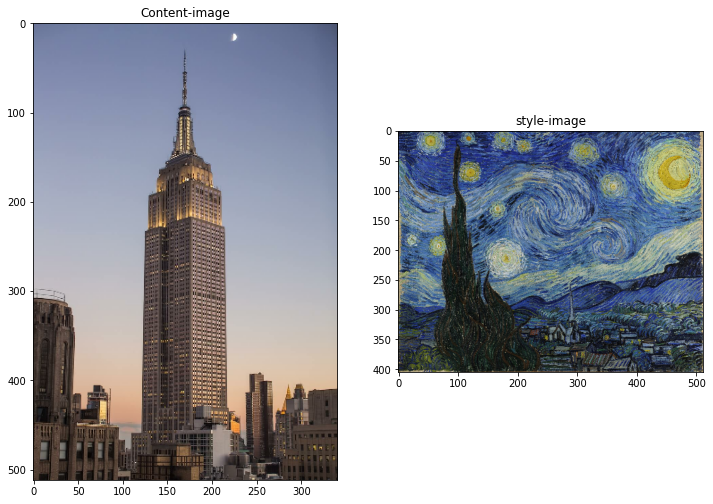

In [4]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content-image')

plt.subplot(1,2,2)
imshow(style_image, 'style-image')

In [5]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (244,244))
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 7, 7, 512])

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    tf_outs = [vgg.get_layer(layer).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], tf_outs)

    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# look at each layers output
for name, tf_out in zip(style_layers, style_outputs):
    print(name)
    print("  shape:  ", tf_out.numpy().shape)
    print("  min:  ", tf_out.numpy().min())
    print("  max:  ", tf_out.numpy().max())
    print("  mean:  ", tf_out.numpy().mean())
    print()

block1_conv1
  shape:   (1, 405, 511, 64)
  min:   0.0
  max:   652.4873
  mean:   24.850803

block2_conv1
  shape:   (1, 202, 255, 128)
  min:   0.0
  max:   2681.6743
  mean:   154.14355

block3_conv1
  shape:   (1, 101, 127, 256)
  min:   0.0
  max:   6229.7285
  mean:   143.91304

block4_conv1
  shape:   (1, 50, 63, 512)
  min:   0.0
  max:   17216.78
  mean:   566.0824

block5_conv1
  shape:   (1, 25, 31, 512)
  min:   0.0
  max:   3835.0444
  mean:   47.042984



In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """expects float input in [0,1]"""
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])


        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value 
                      for style_name, value 
                      in zip(self.style_layers, style_outputs)}
       
        return {'content':content_dict, 'style': style_dict}



In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("  shape:  ", output.numpy().shape)
    print("  min:  ", output.numpy().min())
    print("  max:  ", output.numpy().max())
    print("  mean:  ", output.numpy().mean())

print('Contents:')
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("  shape:  ", output.numpy().shape)
    print("  min:  ", output.numpy().min())
    print("  max:  ", output.numpy().max())
    print("  mean:  ", output.numpy().mean())


Styles:
   block1_conv1
  shape:   (1, 64, 64)
  min:   0.004150984
  max:   23445.492
  mean:   382.3985
   block2_conv1
  shape:   (1, 128, 128)
  min:   0.0
  max:   78957.45
  mean:   10958.144
   block3_conv1
  shape:   (1, 256, 256)
  min:   0.0
  max:   326991.66
  mean:   11000.759
   block4_conv1
  shape:   (1, 512, 512)
  min:   0.0
  max:   4656308.5
  mean:   177993.66
   block5_conv1
  shape:   (1, 512, 512)
  min:   0.0
  max:   122589.88
  mean:   1618.6947
Contents:
   block5_conv2
  shape:   (1, 32, 21, 512)
  min:   0.0
  max:   1267.7899
  mean:   12.88764


In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
image = tf.Variable(content_image)

In [15]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
style_weight=1e-2
content_weight=1e4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])

    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])

    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss

    return loss



In [19]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

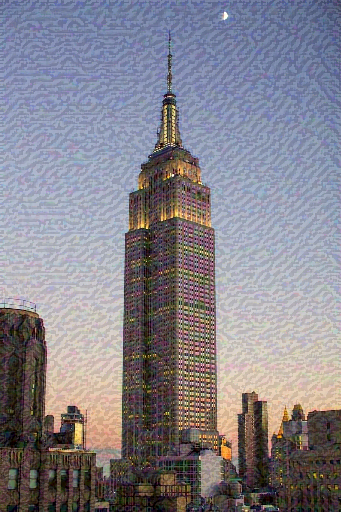

In [20]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


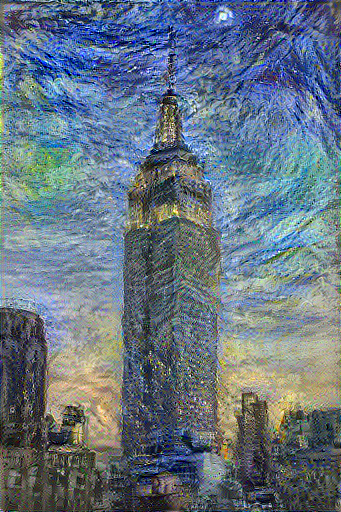

train step: 1000
total time: 1881.0


In [24]:
import time
start = time.time()

epochs = 10 
steps_per_epoch = 100

step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("train step: {}".format(step))

end = time.time()
print("total time: {:.1f}".format(end-start))

In [25]:
def high_pass_x_y(image):
    x_var = image[:,:,1,:] - image[:,:,-1,:]
    y_var = image[:,1,:,:] - image[:-1,:,:]

    return x_var, y_var

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)
# x_deltas
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "horizontal deltas: original")

# plt.subplot(2,2,2)
# imshow(clip_0_1(2*x_deltas+0.5), "vertical deltas: original")

# x_deltas, y_deltas = high_pass_x_y(image)

# plt.subplot(2,2,3)
# imshow(clip_0_1(2*y_deltas+0.5), 'horizontal Deltas: style')

# plt.subplot(2,4,4)
# imshow(clip_0_1(2*x_deltas+0.5), "vertical Deltas:style")

InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 0 [Op:Squeeze]